In [1]:
# !pip install datasets
# !pip install loralib
# !pip install trl
# !pip install accelerate
# !pip install transformers

In [2]:
# !git clone https://github.com/airobotlab/KoChatGPT
# !cp -r KoChatGPT/colossalai_ChatGPT_230319/chatgpt chatgpt

In [3]:
import os

modifications = [
    {
        "file": "chatgpt/trainer/callbacks/save_checkpoint.py",
        "changes": [
            {"line": 3, "old": "from chatgpt.trainer.strategies import ColossalAIStrategy, Strategy",
             "new": "from chatgpt.trainer.strategies import Strategy"},
            {"line": 71, "old": "only_rank0 = not isinstance(self.strategy, ColossalAIStrategy)",
             "new": "            only_rank0 = not isinstance(self.strategy)"},
        ],
    },
    {
        "file": "chatgpt/trainer/strategies/__init__.py",
        "changes": [
            {"line": 1, "old": "from .colossalai import ColossalAIStrategy", "new": ""},  # 삭제
            {"line": 5, "old": "__all__ = ['Strategy', 'NaiveStrategy', 'DDPStrategy', 'ColossalAIStrategy']",
             "new": "__all__ = ['Strategy', 'NaiveStrategy', 'DDPStrategy']"},
        ],
    },
    {
        "file": "chatgpt/dataset/reward_dataset.py",
        "changes": [
            {"line": 3, "old": "from tqdm import tqdm", "new": "from tqdm.notebook import tqdm"},
        ],
    },
    {
        "file": "chatgpt/trainer/base.py",
        "changes": [
            {"line": 8, "old": "from tqdm import tqdm", "new": "from tqdm.notebook import tqdm"},
        ]
    },
    {
        "file": "chatgpt/trainer/rm.py",
        "changes": [
            {"line": 8, "old": "from tqdm import tqdm", "new": "from tqdm.notebook import tqdm"},
        ]
    }
]


def modify_file(file_path, changes):
    """파일에서 지정된 줄을 찾아 내용을 수정하는 함수"""

    if not os.path.exists(file_path):
        print(f"⚠️ 파일이 존재하지 않습니다: {file_path}")
        return

    with open(file_path, "r", encoding="utf-8") as file:
        lines = file.readlines()

    modified = False

    for change in changes:
        line_index = change["line"]
        if 0 <= line_index < len(lines):
            if lines[line_index].strip() == change["old"]:
                lines[line_index] = change["new"] + "\n"
                modified = True
            else:
                print(f"⚠️ {file_path} 파일의 {change['line']}번째 줄이 예상과 다릅니다.")
                print(f"   예상: {change['old']}")
                print(f"   실제: {lines[line_index].strip()}")

    if modified:
        with open(file_path, "w", encoding="utf-8") as file:
            file.writelines(lines)
        print(f"✅ 수정 완료: {file_path}")
    else:
        print(f"⚠️ {file_path} 수정할 내용이 없습니다.")

for mod in modifications:
    modify_file(mod["file"], mod["changes"])

⚠️ chatgpt/trainer/callbacks/save_checkpoint.py 파일의 3번째 줄이 예상과 다릅니다.
   예상: from chatgpt.trainer.strategies import ColossalAIStrategy, Strategy
   실제: from chatgpt.trainer.strategies import Strategy
⚠️ chatgpt/trainer/callbacks/save_checkpoint.py 파일의 71번째 줄이 예상과 다릅니다.
   예상: only_rank0 = not isinstance(self.strategy, ColossalAIStrategy)
   실제: only_rank0 = not isinstance(self.strategy)
⚠️ chatgpt/trainer/callbacks/save_checkpoint.py 수정할 내용이 없습니다.
⚠️ chatgpt/trainer/strategies/__init__.py 파일의 1번째 줄이 예상과 다릅니다.
   예상: from .colossalai import ColossalAIStrategy
   실제: 
⚠️ chatgpt/trainer/strategies/__init__.py 파일의 5번째 줄이 예상과 다릅니다.
   예상: __all__ = ['Strategy', 'NaiveStrategy', 'DDPStrategy', 'ColossalAIStrategy']
   실제: __all__ = ['Strategy', 'NaiveStrategy', 'DDPStrategy']
⚠️ chatgpt/trainer/strategies/__init__.py 수정할 내용이 없습니다.
⚠️ chatgpt/dataset/reward_dataset.py 파일의 3번째 줄이 예상과 다릅니다.
   예상: from tqdm import tqdm
   실제: from tqdm.notebook import tqdm
⚠️ chatgpt/dataset/reward_dataset.py 수

In [4]:
import torch
import transformers
from transformers import AutoTokenizer, AutoModelForCausalLM
import pandas as pd
import numpy

print("Torch version:{}".format(torch.__version__)) # Torch version:1.12.1
print("Cuda version: {}".format(torch.version.cuda)) # Cuda version: 11.3
print("transformers version: {}".format(transformers.__version__)) # transformers 4.28.0
print("GPU 사용 가능여부: {}".format(torch.cuda.is_available()))

# 만일 아래 모듈이 불러와지지 않는다면 Clone 및 수정을 잘 진행했는지 확인해주세요.
from chatgpt.trainer.strategies import NaiveStrategy

Torch version:2.7.1+cu118
Cuda version: 11.8
transformers version: 4.56.1
GPU 사용 가능여부: True


# 2. Base model and Dataset for RLHF

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model_name = "skt/kogpt2-base-v2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name).to(device)

In [6]:
#사용할 모델의 토크나이저가 입력받아 처리할 수 있는 최대 토큰 수를 확인
tokenizer.model_max_length

1000000000000000019884624838656

In [7]:
# kogpt-2 토크나이징 확인
model.config.n_positions

1024

In [8]:
input_txt = "바람도 없는 공중에 수직의 파문을 내이며 고요히 떨어지는 오동잎은 누구의 발자취 입니까."

In [9]:
tokens = tokenizer(input_txt).tokens()
input_ids = tokenizer(input_txt, return_tensors="pt")["input_ids"].numpy()

In [10]:
pd.options.display.max_columns = 40
pd.options.display.max_rows = 60
df = pd.DataFrame([tokens, input_ids[0]], index=["kogpt-2_tokens", "Input_IDs"])
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22
kogpt-2_tokens,▁바람,도,▁없는,▁공중에,▁수직,의,▁파,문을,▁내,이며,▁고,요,히,▁떨어지는,▁오동,잎은,▁누,구의,▁발자,취,▁입,니까,.
Input_IDs,10891,7235,9712,49207,14438,8143,9203,9941,9094,9639,9065,8084,8811,21215,34769,19985,9669,10139,21626,8408,9241,23775,389


In [11]:
# 디코딩 성능 확인
max_length=128
input_ids = tokenizer(input_txt, return_tensors="pt")["input_ids"].to(device)
output_greedy = model.generate(input_ids, max_length=max_length, do_sample=False)
print(tokenizer.decode(output_greedy[0]))

바람도 없는 공중에 수직의 파문을 내이며 고요히 떨어지는 오동잎은 누구의 발자취 입니까.'
"그렇다면 그건 무슨 소리요?"
"그건 무슨 소리요?"
"그건 무슨 소리요?"
"그건 무슨 소리요?"
"그건 무슨 소리요?"
"그건 무슨 소리요?"
"그건 무슨 소리요?"
"그건 무슨 소리요?"
"그건 무슨 소리요?"
"그건 무슨 소리요?"
"그건 무슨 소리요?"
"그건 무슨 소리요?"
"그건 무슨 소리


시퀀스가 반복되어 출력
그리디 서치 디코딩시 발견되는 전형적인 현상.
빔 서치 디코딩을 사용하고 n-gram 패널티까지 부과

In [12]:
input_ids = tokenizer(input_txt, return_tensors="pt")["input_ids"].to(device)
output_beam = model.generate(input_ids, max_length=max_length, num_beams=10, no_repeat_ngram_size=2,
                             do_sample=False)
print(tokenizer.decode(output_beam[0]))

바람도 없는 공중에 수직의 파문을 내이며 고요히 떨어지는 오동잎은 누구의 발자취 입니까.'
"그렇지 않습니다."
"어떻게 된 일입니까?"
그녀는 고개를 갸웃거렸다.
"아니, 그게 무슨 말씀이신지 모르겠습니다만."
"무슨 말씀인지 알 수가 없군요."
아무런 대답도 하지 않은 채 그녀는 고개를 끄덕였다.
"그래, 알았어."
그녀의 눈에서 눈물이 주르륵 흘러내렸다.
그녀가 다시 입을 열었다.
"정말 죄송합니다, 고마워요, 고맙습니다"
"


입력 시퀀스와 별 상관 없어 보이는 긴 문단이 생성.
그럼에도 생성된 문단은 제법 맥락을 갖춘 듯 .
하지만 문장 간의 정합성이나 일관성은 다소 떨어지는 부분도 관찰.
이번엔 샘플링 기법까지 추가

In [13]:
output_beam = model.generate(input_ids, max_length=max_length, num_beams=7, no_repeat_ngram_size=2,
                             do_sample=True, temperature=2.0, top_k=50)
print(tokenizer.decode(output_beam[0]))

바람도 없는 공중에 수직의 파문을 내이며 고요히 떨어지는 오동잎은 누구의 발자취 입니까. ?"
이른 아침 햇살 속에서 아빠는 까맣게 타오르고 있는 달빛 때문에 잠이 들었습니다.
아빠가 잠에 취한 것은 오늘 오후 5시쯤이었습니다.
그리고 이튿날 아침 일찍 일어났습니다.
"이봐, 엄마가 어디서 왔느냐고 물으시오. 엄마는 언제 왔냐고 물어보시오."
"엄마가 왔어요."
"아직 늦지 않았습니다."
엄마는 고개를 끄덕이고 고개를 숙였습니다.
그런데 오늘 아침 엄마와 아


top_p 샘플링 기법도 사용

In [14]:
output_beam = model.generate(input_ids, max_length=max_length, num_beams=7, no_repeat_ngram_size=2,
                             do_sample=True, top_p=0.90)
print(tokenizer.decode(output_beam[0]))

바람도 없는 공중에 수직의 파문을 내이며 고요히 떨어지는 오동잎은 누구의 발자취 입니까.'
"그런데 그건 뭐예요?"
"글쎄, 그게 아닐 거야."
"어쨌든 저는 괜찮아요."
그녀는 고개를 끄덕였다.
"무슨 말씀을 하시는 거죠? 무슨 말씀이신지 모르겠어요. 저도 그 얘기를 들었거든요. 아까도 말씀드렸잖아요, 아줌마. 아저씨도 그런 얘길 하셨어요!"
그러자 그제야 그녀는 한숨을 내쉬었다.



위에서 살펴본 것처럼 단순한 Causal LM에 불과한 kogpt-2는 생성해 낼 문장의 품질을 디코딩 단계에서 인위적으로 조절해주는 방법 밖에 쓸 수 없습니다.
하지만 RLHF를 kogpt-2에 적용한다면 더 좋은 문장을 생성해내는 방법을 모델이 스스로 학습해낼 수 있으리라 기대해 볼 수 있습니다.
고도의 prompting은 어렵겠지만 현재 상태에서 특정 task에 fine-tuning했을 때보다는 성능이 한층 더 개선될 수 있지 않을까요?
kogpt-2에 RLHF를 적용하기기 위해선 새로운 데이터셋으로 일련의 재학습을 해줘야 합니다.
그럼 각 단계별 모델 구현에 앞서 우리가 사용할 데이터셋을 확인해보도록 하겠습니다.
먼저 SFT를 시도할 initial 모델에 쓸 데이터셋을 살펴보겠습니다.

# 데이터셋 확인

In [15]:
import json
data_path_1_SFT = 'KoChatGPT/data_kochatgpt/kochatgpt_1_SFT_new.jsonl'
with open(data_path_1_SFT, "r", encoding='utf-8-sig') as json_file:
    list_data_dict = json.load(json_file)

print(len(list_data_dict))
list_data_dict[:3]

12000


[{'prompt': '불고기용 고기 한우에요?',
  'completion': '불고기용 고기로는 보통 한우가 많이 사용됩니다. 한우는 품질이 뛰어나고 맛이 좋기 때문에 불고기 요리에 적합합니다. 하지만, 다른 종류의 소고기, 예를 들어 미국산 소고기나 호주산 소고기도 사용될 수 있습니다. 결국, 고기의 종류는 개인의 취향과 예산에 따라 다를 수 있습니다. 한우로 불고기를 만들면 더욱 풍부한 맛을 느낄 수 있습니다.',
  'tokens': 126},
 {'prompt': '쓰던 앱이 유료로 전환됐어',
  'completion': '앱이 유료로 전환되면 여러 가지 고민이 생길 수 있습니다. 사용하던 기능이나 서비스가 계속 필요하다면, 유료 결제를 고려해볼 수 있습니다. 하지만 사용 빈도가 낮거나 대안이 충분하다면 다른 무료 앱을 찾아보는 것도 좋은 방법입니다. \n\n어떤 앱인지에 따라 다르겠지만, 몇 가지 대안이나 팁을 드리면:\n\n1. **대안 앱 찾기**: 비슷한 기능을 제공하는 무료 앱을 찾아보세요.\n2. **기능 분석**: 현재 사용 중인 기능 중 정말 필요한 것만 선택하여 유료 결제를 고려할 수 있습니다.\n3. **할인 및 프로모션 확인**: 때때로 앱 개발자들이 할인이나 프로모션을 제공하기도 하니 확인해 보세요.\n4. **사용자 피드백**: 다른 사용자들의 리뷰와 피드백을 참고하여 결정을 내리는 것도 좋습니다.\n\n어떤 앱인지 좀 더 구체적으로 말씀해 주시면, 더 구체적인 조언을 드릴 수 있습니다!',
  'tokens': 292},
 {'prompt': '여친이랑 다툼',
  'completion': '다툼은 어떤 관계에서든 생길 수 있는 일입니다. 중요한 것은 이를 어떻게 해결하느냐입니다. 다음은 몇 가지 팁입니다:\n\n1. **대화하기**: 서로의 감정을 솔직하게 이야기해보세요. 어떤 점에서 상처를 받았는지, 어떤 부분이 불만이었는지를 나누는 것이 중요합니다.\n\n2. **경청하기**: 상대방의 이야기를 잘 들어주는 것이 중요

RM에 사용할 데이터셋 확인

In [16]:
data_path_2_RM = 'KoChatGPT/data_kochatgpt/kochatgpt_2_RM_new.jsonl'
with open(data_path_2_RM, "r", encoding='utf-8-sig') as json_file:
    list_data_dict = json.load(json_file)

print(len(list_data_dict))
list_data_dict[:3]

10220


[{'prompt': '번디는 자신이 탐정잡지, 범죄소설 그리고 성범죄 관련 실제 범죄 다큐멘터리들을 탐독했다고 누구에게 말했나?',
  'completion_0': '번디는 자신이 탐정잡지, 범죄소설 그리고 성범죄 관련 실제 범죄 다큐멘터리들을 탐독했다고 변호사에게 말한 것으로 알려져 있습니다.',
  'completion_1': 'Allow me to answer your question. I know that you are curious about me.',
  'completion_2': '라이언에게 말했다.',
  'completion_3': '번디는 다양한 인터뷰자들과 뉴스홍보 담당자들과의 면담 때 밝혔다.',
  'ranking': [0, 3, 1, 2]},
 {'prompt': '개포주공아파트는 몇 단지로 이루어져 있나?',
  'completion_0': '개포주공아파트는 총 27개 단지로 이루어져 있습니다.',
  'completion_1': '개포주공아파트는 다섯 단지로 이루어져 있습니다.',
  'completion_2': '이날 목송에서 구글상위노',
  'completion_3': '죄송합니다. 개포주공아파트의 구체적인 단지 수에 대한 정보는 제공할 수 없습니다. 자세한 정보는 지역 부동산이나 관련 공식 웹사이트를 참고하시기 바랍니다.',
  'ranking': [2, 3, 1, 0]},
 {'prompt': '김영삼의 후보 시절 지역표심을 겨냥한 발언을 문제삼은 후보는?',
  'completion_0': '김영삼의 후보 시절에 지역표심을 겨냥한 발언은 대통령 당선 전까지 대한민국 정부가 추구하고 있는 민주주의 광범위하게 확립과 보수의 사상을 이어가는 데 있어 지역경제 발전과 공공서비스 신속 개선을 위해 합리적인 국가 정책에 따르는 방향성을 제시하고 있습니다.',
  'completion_1': '죄송하지만, 김영삼의 후보 시절 특정 발언을 문제삼은 후보에 대한 정보는 없습니다. 추가적인 자료나 맥락이 필요할 수 있습니다.',
  '

 PPO 학습에 쓰일 데이터 확인

In [17]:
data_path_3_PPO = 'KoChatGPT/data_kochatgpt/kochatgpt_3_PPO.jsonl'
with open(data_path_3_PPO, "r", encoding='utf-8-sig') as json_file:
    list_data_dict = json.load(json_file)

print(len(list_data_dict))
list_data_dict[:3]

12000


[{'prompt': '번디는 자신이 탐정잡지, 범죄소설 그리고 성범죄 관련 실제 범죄 다큐멘터리들을 탐독했다고 누구에게 말했나?'},
 {'prompt': '개포주공아파트는 몇 단지로 이루어져 있나?'},
 {'prompt': '김영삼의 후보 시절 지역표심을 겨냥한 발언을 문제삼은 후보는?'}]

# 3. Supervised Fine-Tuning

SFT
이번 스텝에서는 kogpt-2를 instruction dataset으로 SFT를 진행

In [18]:
from typing import Optional, Dict, Sequence
from torch.utils.data import Dataset
from dataclasses import dataclass
import logging
import copy

In [19]:
# 모델, 토크나이저 호출

model = AutoModelForCausalLM.from_pretrained('skt/kogpt2-base-v2')
tokenizer = AutoTokenizer.from_pretrained(
    'skt/kogpt2-base-v2', bos_token='</s>', eos_token='</s>', unk_token='</s>', pad_token='</s>',
    padding_side="right",
    model_max_length=512,
)

print(tokenizer)

GPT2TokenizerFast(name_or_path='skt/kogpt2-base-v2', vocab_size=51200, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '</s>', 'eos_token': '</s>', 'unk_token': '</s>', 'pad_token': '</s>'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	0: AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("<usr>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	3: AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	4: AddedToken("<sys>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	5: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	6: AddedToken("<mask>", rstrip=False, lstrip=False, single_word=

추가 토큰 정보 (added_tokens_decoder):

skt/kogpt2-base-v2 토크나이저가 기본적으로 가지고 있는 모든 특수 토큰의 목록입니다.

<usr>, <sys>, <unused0>~<unused99>, 이모티콘(:-)) 및 이모지(😀, 😠 등)가 포함되어 있는 것을 볼 수 있습니다. 이렇게 긴 목록이 나타나는 것은 원래 토크나이저의 사양이므로 전혀 문제없습니다.

In [20]:
# 모델 인퍼런스 단계에서 사용할 prompt 딕셔너리 템플릿과 SFT 데이터셋 클래스를 정의

class SFT_dataset(Dataset):

    def __init__(self, data_path_1_SFT: str, tokenizer: transformers.PreTrainedTokenizer, verbose=False):
        super(SFT_dataset, self).__init__()
        logging.warning("Loading data...")

        pattern_instruction = 'prompt'  # instruction
        pattern_output = 'completion'  # response

        with open(data_path_1_SFT, "r", encoding='utf-8-sig') as json_file:
            list_data_dict = json.load(json_file)

        PROMPT_DICT = {
            "prompt_input": (
                "### Instruction(명령어):\n{prompt}\n\n### Response(응답):"
            )
        }

        prompt_input = PROMPT_DICT["prompt_input"]

        sources = []
        for example in list_data_dict:
            tmp = prompt_input.format_map(example)
            sources.append(tmp)

        targets = []
        for example in list_data_dict:
            targets.append(f"{example[pattern_output]}{tokenizer.eos_token}")
        examples = [s + t for s, t in zip(sources, targets)]

        sources_tokenized = self._tokenize_fn(sources, tokenizer)  # source
        examples_tokenized = self._tokenize_fn(examples, tokenizer)  # source + target

        input_ids = examples_tokenized["input_ids"]
        labels = copy.deepcopy(input_ids)
        for label, source_len in zip(labels, sources_tokenized["input_ids_lens"]):
            label[:source_len] = -100

        data_dict = dict(input_ids=input_ids, labels=labels)

        self.input_ids = data_dict["input_ids"]
        self.labels = data_dict["labels"]
        logging.warning("Loading data done!!: %d"%(len(self.labels)))


    def _tokenize_fn(self, strings: Sequence[str], tokenizer: transformers.PreTrainedTokenizer) -> Dict:
        tokenized_list = [
            tokenizer(
                text,
                return_tensors="pt",
                padding="longest",
                max_length=tokenizer.model_max_length,
                truncation=True,
            )
            for text in strings
        ]
        input_ids = labels = [tokenized.input_ids[0] for tokenized in tokenized_list]
        input_ids_lens = labels_lens = [
            tokenized.input_ids.ne(tokenizer.pad_token_id).sum().item() for tokenized in tokenized_list
        ]
        return dict(
            input_ids=input_ids,
            labels=labels,
            input_ids_lens=input_ids_lens,
            labels_lens=labels_lens,
        )


    def __len__(self):
        return len(self.input_ids)


    def __getitem__(self, i) -> Dict[str, torch.Tensor]:
        return dict(input_ids=self.input_ids[i], labels=self.labels[i])

In [21]:
@dataclass
class DataCollatorForSupervisedDataset(object):

    tokenizer: transformers.PreTrainedTokenizer

    def __call__(self, instances: Sequence[Dict]) -> Dict[str, torch.Tensor]:
        input_ids, labels = tuple([instance[key] for instance in instances] for key in ("input_ids", "labels"))
        input_ids = torch.nn.utils.rnn.pad_sequence(
            input_ids, batch_first=True, padding_value=self.tokenizer.pad_token_id
        )
        labels = torch.nn.utils.rnn.pad_sequence(labels, batch_first=True, padding_value= -100)
        return dict(
            input_ids=input_ids,
            labels=labels,
            attention_mask=input_ids.ne(self.tokenizer.pad_token_id),
        )

In [22]:
# SFT_dataset 클래스를 사용해 훈련셋을 만들고 data collator 인스턴스 생성

train_dataset = SFT_dataset(data_path_1_SFT='KoChatGPT/data_kochatgpt/kochatgpt_1_SFT_new.jsonl', tokenizer=tokenizer)
data_collator = DataCollatorForSupervisedDataset(tokenizer=tokenizer)

print('input : %s'%train_dataset.input_ids[0])
print('output: %s'%train_dataset.labels[0])

input : tensor([  739,   378,   378,   378, 14659, 13394, 37091, 10651,   383, 25841,
         8006, 14914,   375,  7673, 20479,  8091, 22311,  9036, 30902, 13675,
          375,   378,   378,   378, 41951,   454,  9549, 20549,   383,  8142,
         7192, 14914,  7673, 20479,  8091, 22311,  9460, 10162,  9036, 15576,
         9564,  9209,  7255, 12521,  9036, 12168, 28558, 32862, 15882,  9677,
         6958,  9355,  9128, 20479,  9242,  9556, 13295, 37194, 15197,  9306,
        12317,  9077,  6889, 10163, 10795,  9359,  9528,  7759,  9077,  6889,
        17160, 27531,  7759,  9077,  6889,  9313, 35773,  9025, 32987, 44377,
         9065,  9480, 18250, 12695,  9499, 21253,  9182, 11873,  9161, 19996,
         9025, 32987, 33869,  7426,  9128,  6889,  9368,  9695,  7532,  9947,
        12923, 21855, 20166,  9025, 32987,     1])
output: tensor([ -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
         -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -10

In [23]:
# 디코딩 함수 작성
def decode_tokens(tokenizer, input_ids, label_ids):
  """
  주어진 input_ids와 label_ids를 디코딩하여 원본 text를 출력하는 함수.
  label_ids에 포함된 -100 값은 디코딩에서 제외합니다.
  """
  # input_ids 디코딩
  # skip_special_tokens=True 옵션으로 </s>와 같은 특수 토큰을 제외하고 볼 수 있습니다.
  decoded_input = tokenizer.decode(input_ids, skip_special_tokens=True)
  
  # label_ids에서 -100을 제외한 토큰만 필터링
  filtered_label_ids = [token_id for token_id in label_ids if token_id != -100]
  
  # 필터링된 label_ids 디코딩
  decoded_label = tokenizer.decode(filtered_label_ids, skip_special_tokens=True)
  
  print("--- [디코딩 결과] ---")
  print(f"➡️ Input (전체 원본 문장):\n{decoded_input}\n")
  print(f"✅ Label (모델이 학습하는 정답 문장):\n{decoded_label}")

# 함수를 사용하여 첫 번째 데이터 확인
decode_tokens(
    tokenizer, 
    train_dataset.input_ids[0], 
    train_dataset.labels[0]
)

--- [디코딩 결과] ---
➡️ Input (전체 원본 문장):
### Instruction(명령어):
불고기용 고기 한우에요?

### Response(응답):불고기용 고기로는 보통 한우가 많이 사용됩니다. 한우는 품질이 뛰어나고 맛이 좋기 때문에 불고기 요리에 적합합니다. 하지만, 다른 종류의 소고기, 예를 들어 미국산 소고기나 호주산 소고기도 사용될 수 있습니다. 결국, 고기의 종류는 개인의 취향과 예산에 따라 다를 수 있습니다. 한우로 불고기를 만들면 더욱 풍부한 맛을 느낄 수 있습니다.

✅ Label (모델이 학습하는 정답 문장):
불고기용 고기로는 보통 한우가 많이 사용됩니다. 한우는 품질이 뛰어나고 맛이 좋기 때문에 불고기 요리에 적합합니다. 하지만, 다른 종류의 소고기, 예를 들어 미국산 소고기나 호주산 소고기도 사용될 수 있습니다. 결국, 고기의 종류는 개인의 취향과 예산에 따라 다를 수 있습니다. 한우로 불고기를 만들면 더욱 풍부한 맛을 느낄 수 있습니다.


In [24]:
# Training arguments를 사용해 trainer 클래스를 정의

training_args = transformers.TrainingArguments(
    output_dir="test",
    overwrite_output_dir=True,
    num_train_epochs=1,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=5,
    prediction_loss_only=True,
    fp16 = True
    )
trainer = transformers.Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset
)

In [25]:
# SFT 훈련을 진행

trainer.train()
model.save_pretrained('models/output_1_SFT')

`loss_type=None` was set in the config but it is unrecognized. Using the default loss: `ForCausalLMLoss`.


Step,Training Loss
500,2.517400
1000,2.298500
1500,2.201200


In [26]:
# 문장 생성 능력을 확인하기 위해 빠르게 허깅페이스의 pipleline 클래스를 사용하여 generator 구현

generator = transformers.pipeline('text-generation', model='models/output_1_SFT', tokenizer=tokenizer)

generation_args = dict(
    num_beams=4,
    repetition_penalty=2.0,
    no_repeat_ngram_size=4,
    eos_token_id=375, # \n
    max_new_tokens=64,
    do_sample=True,
    top_k=50,
    early_stopping=True
)

PROMPT_DICT = {
    "prompt_input": (
        "### Instruction(명령어):\n{prompt}\n\n### Response(응답):"
    )
}

list_prompt = ['불고기용 고기 한우에요?',
               '리처드 닉슨이 43대 부통령직을 수행한 년도는?',
               '시카고 오헤어 국제공항은 어디에 있어?',
               '오늘 미세먼지 어때?']

list_prompt = [PROMPT_DICT['prompt_input'].format_map({'prompt' : tmp}) for tmp in list_prompt]

list_result = generator(list_prompt, **generation_args)
for prompt, result in zip(list_prompt, list_result):
    print()
    print((result[0]['generated_text']))

Device set to use cuda:0



### Instruction(명령어):
불고기용 고기 한우에요?

### Response(응답):불고기용 고기는 일반적으로 소고기, 돼지고기, 양고기 등 다양한 부위를 혼합하여 조리하는 경우가 많습니다. 불고기용 고기를 주문할 때는 다음과 같은 점을 고려해보세요:


### Instruction(명령어):
리처드 닉슨이 43대 부통령직을 수행한 년도는?

### Response(응답):리처드 닉슨은 46대 부통령직을 수행했습니다. 그는 1946년부터 1949년까지 재임하였습니다. "리처드 닉슨"이라는 이름은 그의 정치적 경력에서 중요한 역할을 한 인물 중 하나입니다. "리처드슨"이라는 이름은 미국의 정치 역사에서 중요한 인물로 여겨집니다. "이시카와 히데요시" 또는 "리처

### Instruction(명령어):
시카고 오헤어 국제공항은 어디에 있어?

### Response(응답):오헤어 국제공항(Cross Airport)은 미국 캘리포니아주 로스앤젤레스(Los Angeles)에 위치해 있습니다. 이 공항은 세계에서 가장 큰 국제공항 중 하나로, 다양한 항공편과 서비스가 제공됩니다. 추가적인 정보가 필요하시면 말씀해 주세요!高?高ч

### Instruction(명령어):
오늘 미세먼지 어때?

### Response(응답):오늘 미세먼지에 대해 궁금하신 점이 있으신가요? 도움이 필요하시면 말씀해 주세요!しンンン)은 고대 중국의 불교에서 중요한 경전 중 하나로 여겨집니다. 이 경전은 다음과 같은 내용을 담고 있습니다:



SFT 모델의 성능은 어떤가요?

SFT 단계를 최적화하기 위해선 무엇보다도 instruction dataset의 품질과 initial모델의 언어모델링 성능이 중요합니다.

GPT를 새로 pretrain 하여 언어모델 성능을 도약시키는 일은 우리의 학습목표를 넘어서는 일이니 우선은 데이터셋 전처리를 더 수행하고 최상의 디코딩 전략이 적용된 generator를 설계한다면 더 나은 성능을 기대해 볼 수 있을 것입니다.

하지만 지금은 baseline을 빠르게 돌려보는 게 목적입니다.

이제 다음 단계인 reward modeling으로 넘어가 보도록 하겠습니다.

메모리 관리를 위해 캐시를 비우고 넘어가겠습니다.

In [27]:
torch.cuda.empty_cache()

# 4. Reward Model

In [28]:
from chatgpt.dataset import RewardDataset
from chatgpt.models.base import RewardModel
from chatgpt.trainer.strategies import NaiveStrategy
from chatgpt.trainer.rm import RewardModelTrainer

from transformers.models.gpt2.configuration_gpt2 import GPT2Config
from transformers.models.gpt2.modeling_gpt2 import GPT2Model

import torch.nn as nn

import random

Import된 라이브러리들을 보면 SFT단계에서 사용했던 것과는 다른 모듈들이 몇 개 눈에 띕니다.

우선 chatgpt 폴더 안에 있는 RM 관련 모듈들이 눈에 띄네요.
NaiveStrategy라는 모듈도 있습니다.

원본 깃헙 레포짓에는 multi GPU를 사용해서도 KoChatGPT를 실습해볼 수 있도록 하고 있지만 우리는 single GPU를 사용해야 하는 환경이므로 학습전략을 고정시켜놓기 위해 해당 모듈을 따로 import했습니다.

마지막엔 허깅페이스의 transformers에서 gpt2 모델 관련 모듈들도 사용하고 있네요.

In [29]:
class GPTRM_custom(RewardModel):

    def __init__(self,
                 pretrained: Optional[str] = None,
                 config: Optional[GPT2Config] = None,
                 checkpoint: bool = False,
                 lora_rank: int = 0,
                 lora_train_bias: str = 'none',
                 tokenizer=None) -> None:
        if pretrained is not None:
            model = GPT2Model.from_pretrained(pretrained)
            model.resize_token_embeddings(len(tokenizer))
        elif config is not None:
            model = GPT2Model(config)
        else:
            model = GPT2Model(GPT2Config())
        if checkpoint:
            model.gradient_checkpointing_enable()

        value_head = nn.Linear(model.config.n_embd, 1) 
        # ★ model.config.n_embd: GPT-2의 내부 은닉 상태 벡터의 차원(예: 768, 1024 등).
        # 1: 최종적으로 하나의 보상 값(스칼라)을 출력하기 위한 차원.
        
        super().__init__(model, value_head, lora_rank, lora_train_bias)

        if pretrained is not None:
            self.model = model
            self.pretrained = pretrained


    def save_pretrained(self, dir):
        if self.pretrained is not None:
            self.model.save_pretrained(dir)

In [30]:
model = AutoModelForCausalLM.from_pretrained('skt/kogpt2-base-v2')
tokenizer = AutoTokenizer.from_pretrained(
    'skt/kogpt2-base-v2', bos_token='</s>', eos_token='</s>', unk_token='</s>', pad_token='</s>',
    padding_side="right",
    model_max_length=512,
)

with NaiveStrategy().model_init_context():
        model = GPTRM_custom(pretrained='skt/kogpt2-base-v2', lora_rank=0, tokenizer=tokenizer).cuda()

In [32]:
#  RM을 훈련시킬 때 사용할 ranking dataset
#  completion이 4개가 되었으므로 code를 아래와 같이 변경해야함


with open('KoChatGPT/data_kochatgpt/kochatgpt_2_RM_new.jsonl', "r", encoding='utf-8-sig') as json_file:
    list_data_dict = json.load(json_file)

total_data_ranking2chosen = []
# for tmp in list_data_dict:
#     one_data_ranking2chosen = []

#     data = {}
#     data['prompt'] = tmp['prompt']
#     if tmp['ranking'][0] < tmp['ranking'][1]:
#         data['chosen'] = tmp['completion_0']
#         data['rejected'] = tmp['completion_1']
#     else:
#         data['chosen'] = tmp['completion_1']
#         data['rejected'] = tmp['completion_0']
#     one_data_ranking2chosen.append(data)

#     data = {}
#     data['prompt'] = tmp['prompt']
#     if tmp['ranking'][0] < tmp['ranking'][2]:
#         data['chosen'] = tmp['completion_0']
#         data['rejected'] = tmp['completion_2']
#     else:
#         data['chosen'] = tmp['completion_2']
#         data['rejected'] = tmp['completion_0']
#     one_data_ranking2chosen.append(data)

#     data = {}
#     data['prompt'] = tmp['prompt']
#     if tmp['ranking'][1] < tmp['ranking'][2]:
#         data['chosen'] = tmp['completion_1']
#         data['rejected'] = tmp['completion_2']
#     else:
#         data['chosen'] = tmp['completion_2']
#         data['rejected'] = tmp['completion_1']
#     one_data_ranking2chosen.append(data)



#     total_data_ranking2chosen.extend(one_data_ranking2chosen)

import itertools

for tmp in list_data_dict:
        one_data_ranking2chosen = []
        
        # 4개 completion의 모든 쌍을 생성 (0,1), (0,2), (0,3), (1,2), (1,3), (2,3)
        completion_pairs = list(itertools.combinations([0, 1, 2, 3], 2))
        
        for i, j in completion_pairs:
            data = {}
            data['prompt'] = tmp['prompt']
            
            # 랭킹이 낮을수록 더 좋은 답변 (0이 최고, 3이 최저)
            if tmp['ranking'][i] < tmp['ranking'][j]:
                data['chosen'] = tmp[f'completion_{i}']
                data['rejected'] = tmp[f'completion_{j}']
            else:
                data['chosen'] = tmp[f'completion_{j}']
                data['rejected'] = tmp[f'completion_{i}']
            
            one_data_ranking2chosen.append(data)
        
        total_data_ranking2chosen.extend(one_data_ranking2chosen)

print('before data num: %d'%(len(list_data_dict)))
print('after  data num: %d'%(len(total_data_ranking2chosen)))
print('data example: \n%s'%total_data_ranking2chosen[45])

before data num: 10220
after  data num: 61320
data example: 
{'prompt': '지루가 데뷔골을 넣은 경기는 어느팀과의 경기였나?', 'chosen': '지루가 데뷔골을 넣은 경기는 2016년 8월 20일 KRC 격돌 웨스트로엔 경기였습니다.', 'rejected': '제목들 개인권 회장 개인권 회장\n\n1. 한국 트랙 개인권 회장\n\n2. 고츠 트랙 개인권 회장\n\n3. 뷰틀 개인권 회장\n\n4. 근'}


kochatgpt_2_RM.jsonl 은
chatGPT, davinch, ada 세개 모델에 같은 prompt를 주고 얻은 세 답변을
순서대로 good, bad, worst로 간주해
순서를 뒤섞어 completion_0, completion_1, completion_2 세 키에 할당하여 만든 데이터셋입니다.
위와 같이 코드를 짜게 되면 chosen과 resjected에 각각
completion_0, completion_1, completion_2 세개 답변이 가능한 모든 조합으로 들어가게 되어
chosen에 worst 답변이 들어가고
rejected에 good답변이 들어간 데이터도 만들어집니다.

In [33]:
# 빠르게 돌려보기 위해 전체 데이터중 일부만 학습

import random
random.seed(230319)
random.shuffle(total_data_ranking2chosen)
print(total_data_ranking2chosen[45])

{'prompt': '2009년 조선민주주의인민공화국 해군 함정이 불법 침입한 곳은?', 'chosen': '2009년 조선민주주의인민공화국 해군 함정이 불법 침입한 곳은 동해방위선에 있는 일본 국경 안에 있는 일본 해상 영토입니다.', 'rejected': '조선민주의인민공화국 해군 함정이 불법 침입한 곳은?'}


In [34]:
train_data = total_data_ranking2chosen[:1000]
eval_data = total_data_ranking2chosen[1000:1200]

print(len(train_data))
print(len(eval_data))

train_dataset = RewardDataset(train_data, tokenizer, 512)
eval_dataset = RewardDataset(eval_data, tokenizer, 512)

1000
200


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

In [35]:
# 데이터셋이 잘 만들어졌는지 하나를 뽑아 확인

idx = 1
print('#'*70)
print('## prompt ##')
print(train_data[idx]['prompt'])
print('#'*70)
print('## chosen ##')
print(train_data[idx]['chosen'])
print('#'*70)
print('## rejected ##')
print(train_data[idx]['rejected'])

######################################################################
## prompt ##
해빌랜드는 모권제를 무엇으로 정의했어
######################################################################
## chosen ##
죄송하지만 에드워드 해빌랜드가 모권제를 어떻게 정의했는지에 대한 정보는 없습니다. 해빌랜드의 특정 정의나 설명이 필요하다면 관련된 저서나 논문을 참조하시는 것이 좋습니다.
######################################################################
## rejected ##
요?

해빌랜드는 모권제를 “개인이나 기업이 소유하고 있는 자산의 가치를 증가시키기 위해 사용하는 기술 및 전략”으로 정의했습니다.


In [36]:
# RM을 학습
trainer = RewardModelTrainer(model=model,
                             strategy=NaiveStrategy(),
                             optim=torch.optim.Adam(model.parameters(), lr=5e-5),
                             train_dataset=train_dataset,
                             eval_dataset=eval_dataset,
                             batch_size=4,
                             max_epochs=1)

In [37]:
trainer.fit(use_lora=0)

model.save_pretrained('models/output_2_RM')

Train epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Train step of epoch 0:   0%|          | 0/250 [00:00<?, ?it/s]

In [38]:
# 임의의 문장을 입력한 후 reward score를 출력

def inference_RM(input_text):
    input_ids = tokenizer.encode(input_text, return_tensors='pt').cuda()
    output = model(input_ids)
    output_reward = output.cpu().detach().numpy()[0]

    print('input: %s\nreward score: %.1f'%(input_text, output_reward))

    return output_reward

input_text = '인공지능은 똥멍청이 입니다'
output_reward = inference_RM(input_text=input_text)

input: 인공지능은 똥멍청이 입니다
reward score: -0.8


In [39]:
input_text = '인공지능(AI)은 컴퓨터에서 음성 및 작성된 언어를 보고 이해하고 번역하고 데이터를 분석하고 추천하는 기능을 포함하여 다양한 고급 기능을 수행할 수 있는 일련의 기술입니다.'

output_reward = inference_RM(input_text=input_text)

input: 인공지능(AI)은 컴퓨터에서 음성 및 작성된 언어를 보고 이해하고 번역하고 데이터를 분석하고 추천하는 기능을 포함하여 다양한 고급 기능을 수행할 수 있는 일련의 기술입니다.
reward score: -1.0


In [40]:
input_text = "인공지능(AI)은 컴퓨터에서 음성 및 작성된 언어를 보고 이해하고 번역하고 데이터를 분석하고 추천하는 기능을 포함하여 다양한 고급 기능을 수행할 수 있는 일련의 기술입니다. AI는 현대적인 컴퓨팅 혁신에서 중추적인 역할을 하며 개인과 비즈니스의 가치를 창출합니다. 예를 들어 광학 문자 인식(OCR)은 AI를 사용해 이미지 및 문서에서 텍스트 및 데이터를 추출하고, 구조화되지 않은 콘텐츠를 비즈니스에 바로 사용할 수 있게 만들고, 유용한 정보를 창출합니다."

output_reward = inference_RM(input_text=input_text)

input: 인공지능(AI)은 컴퓨터에서 음성 및 작성된 언어를 보고 이해하고 번역하고 데이터를 분석하고 추천하는 기능을 포함하여 다양한 고급 기능을 수행할 수 있는 일련의 기술입니다. AI는 현대적인 컴퓨팅 혁신에서 중추적인 역할을 하며 개인과 비즈니스의 가치를 창출합니다. 예를 들어 광학 문자 인식(OCR)은 AI를 사용해 이미지 및 문서에서 텍스트 및 데이터를 추출하고, 구조화되지 않은 콘텐츠를 비즈니스에 바로 사용할 수 있게 만들고, 유용한 정보를 창출합니다.
reward score: -1.0


In [41]:
input_text = "인공지능은 일반적으로 인간의 지능이 필요하거나 인간이 분석할 수 있는 것보다 규모가 큰 데이터를 포함하는 방식으로 추론, 학습 및 행동할 수 있는 컴퓨터 및 기계를 구축하는 것과 관련된 과학 분야입니다. AI는 컴퓨터 공학, 데이터 분석 및 통계, 하드웨어 및 소프트웨어 엔지니어링, 언어학, 신경 과학은 물론 철학과 심리학을 포함하여 여러 학문을 포괄하는 광범위한 분야입니다. 비즈니스의 운영 수준에서 AI는 주로 머신러닝과 딥 러닝을 기반으로 하는 기술 모음으로, 데이터 분석, 예상 및 예측, 객체 분류, 자연어 처리, 추천, 지능형 데이터 가져오기 등을 수행할 수 있습니다."

output_reward = inference_RM(input_text=input_text)

input: 인공지능은 일반적으로 인간의 지능이 필요하거나 인간이 분석할 수 있는 것보다 규모가 큰 데이터를 포함하는 방식으로 추론, 학습 및 행동할 수 있는 컴퓨터 및 기계를 구축하는 것과 관련된 과학 분야입니다. AI는 컴퓨터 공학, 데이터 분석 및 통계, 하드웨어 및 소프트웨어 엔지니어링, 언어학, 신경 과학은 물론 철학과 심리학을 포함하여 여러 학문을 포괄하는 광범위한 분야입니다. 비즈니스의 운영 수준에서 AI는 주로 머신러닝과 딥 러닝을 기반으로 하는 기술 모음으로, 데이터 분석, 예상 및 예측, 객체 분류, 자연어 처리, 추천, 지능형 데이터 가져오기 등을 수행할 수 있습니다.
reward score: -0.9


input text가 더 좋아질수록 reward score가 점진적으로 상승하나요?

각 reward score 값이 적절해 보이시나요?

reward score가 음수가 된다는 건 어떤 의미일까요?

그 전에 reward score가 음수도 될 수 있도록 하려면 어떻게 해야 할까요?

RM의 출력인 reward score가 scalar가 되도록 하는 게 왜 중요할까요?

RLHF의 마지막 단계인 PPO 학습을 통해 살펴보도록 하겠습니다.

여기서도 메모리 관리를 위해 한 번더 캐시를 비우고 넘어가겠습니다.

In [42]:
torch.cuda.empty_cache()

# 5. Proximal Policy Optimization

In [43]:
from chatgpt.models.gpt import GPTActor, GPTCritic
from chatgpt.trainer import PPOTrainer

from copy import deepcopy

노드에서 소개하는 KoChatGPT의 경우 PPO에 사용할 actor모델은 1단계 SFT 모델을, critic모델은 2단계 RM 모델을 사용합니다.

그리고 actor 모델이 critic 모델로부터 피드백을 받아 파라미터를 업데이트 할 때 적절한 페널티를 줄 수 있도록 하는 initial model은 SFT모델을 그대로 freezing 하여 사용합니다.
토크나이저는 pretrain 모델인 kogpt-2의 토크나이저를 그대로 사용
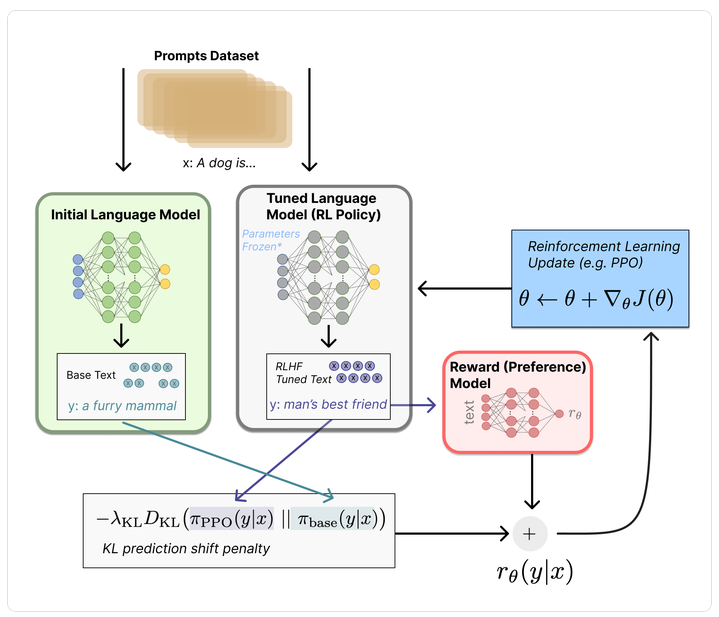

In [44]:
with NaiveStrategy().model_init_context():
    actor = GPTActor(pretrained='models/output_1_SFT', lora_rank=0).to(torch.cuda.current_device())
    critic = GPTCritic(pretrained='models/output_2_RM', lora_rank=0).to(torch.cuda.current_device())
    tokenizer = AutoTokenizer.from_pretrained(
        'skt/kogpt2-base-v2', bos_token='</s>', eos_token='</s>', unk_token='</s>', pad_token='</s>',
        padding_side="right",
        model_max_length=512
    )
    initial_model = deepcopy(actor)
    reward_model = RewardModel(deepcopy(critic.model), deepcopy(critic.value_head)).to(torch.cuda.current_device())

In [45]:
actor_optim = torch.optim.Adam(actor.parameters(), lr=5e-6)
critic_optim = torch.optim.Adam(critic.parameters(), lr=5e-6)

In [46]:
(actor, actor_optim), (critic, critic_optim), reward_model, initial_model = NaiveStrategy().prepare(
    (actor, actor_optim), (critic, critic_optim), reward_model, initial_model)

In [47]:
with open('KoChatGPT/data_kochatgpt/kochatgpt_3_PPO.jsonl', "r", encoding='utf-8-sig') as json_file:
    list_data_dict = json.load(json_file)
    list_prompt = [tmp['prompt'] for tmp in list_data_dict]

def tokenize_fn(texts):
    batch = tokenizer(texts, return_tensors='pt', max_length=96, padding=True, truncation=True)
    return {k: v.cuda() for k, v in batch.items()}

In [48]:
print(tokenize_fn('It takes something more than intelligence to act intelligently.'))

{'input_ids': tensor([[47311, 10448, 19008,  9792, 11780, 11308, 30190, 10929, 11849, 21663,
         44389,  9574, 13799,   458, 14308, 12778, 22469, 20938, 44696,   458,
         13799,   458, 14308, 12778, 11756, 18944,   389]], device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1]], device='cuda:0')}


In [49]:
len(list_prompt)

12000

PPO는 별도의 PPOTrainer 클래스를 설계하여 학습시켜줘야 합니다.

빠르게 실습해보기 위해 1epoch만 돌려보겠습니다.

In [50]:
trainer = PPOTrainer(NaiveStrategy(),
                     actor,
                     critic,
                     reward_model,
                     initial_model,
                     actor_optim,
                     critic_optim,
                     max_epochs=1,
                     train_batch_size=8,
                     tokenizer=tokenize_fn,
                     max_length=128,
                     do_sample=True,
                     temperature=1.0,
                     top_k=50,
                     pad_token_id=tokenizer.pad_token_id,
                     eos_token_id=tokenizer.eos_token_id)

PPO는 SFT, RM 보다 훨씬 복잡한 단계로 설계되는 강화학습 알고리즘입니다.

PPO의 loss function은 chatgpt/models 폴더 내의 loss.py 모듈에서 PolicyLoss와 ValueLoss 클래스에 정의되어 있습니다.

PPO 학습을 진행

In [51]:
trainer.fit(list_prompt,
            num_episodes=10,
            max_timesteps=3,
            update_timesteps=3)

actor.model.save_pretrained('models/output_3_PPO')

Episode [1/10]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/1]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [2/10]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/1]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [3/10]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/1]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [4/10]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/1]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [5/10]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/1]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [6/10]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/1]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [7/10]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/1]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [8/10]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/1]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [9/10]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/1]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [10/10]:   0%|          | 0/3 [00:00<?, ?it/s]

Train epoch [1/1]:   0%|          | 0/3 [00:00<?, ?it/s]

드디어 SFT, RM 그리고 PPO 학습이 모두 완료되었습니다.
RLHF가 적용된 koGPT-2의 생성능력을 확인해볼까요?

In [52]:
def generation(input_text, model):
    input_ids = tokenizer.encode(input_text, return_tensors='pt').to(
        torch.cuda.current_device())
    outputs = model.generate(input_ids,
                             max_length=250,
                             do_sample=True,
                             top_k=50,
                             top_p=0.95,
                             num_return_sequences=1)
    output = tokenizer.batch_decode(outputs[0], skip_special_tokens=True)[0]
    print()
    print(output)
    return output

PROMPT_DICT = {
    "prompt_input": (
        "### Instruction(명령어):\n{prompt}\n\n### Response(응답):"
    )
}

list_prompt = [
    '불고기용 고기 한우에요?',
    '리처드 닉슨이 43대 부통령직을 수행한 년도는?',
    '시카고 오헤어 국제공항은 어디에 있어',
    '오늘 미세먼지 어때?']

list_prompt = [PROMPT_DICT['prompt_input'].format_map({'prompt': tmp}) for tmp in list_prompt]

for input_text in list_prompt:
    output = generation(input_text, actor)


### Instruction(명령어):
불고기용 고기 한우에요?

### Response(응답):불고기용 고기 구매할 때는 부위 선택에 따라 다양하게 선택할 수 있습니다. 일반적으로 불고기는 부위마다 맛과 색상이 다르므로, 취향에 맞는 고기를 선택하세요! 예를 들어, 비비고, 오겹살, 피망 등 몇 가지 부위의 불고기를 추천합니다. 어떤 부위나 부위가 불고기를 더 선호하는지 궁금하네요. 윙윙
### 가격 참고:

##### 가격표:
### 가격, 부위 선택:

1. **부위**: 일반적으로 가장 인기가 높은 부위이기도 하며, 각 부위마다 가격이 다를 수 있습니다.

2. **부위**: 고기 부위 중에서 가장 인기가 높습니다.
2. **부위**: 부위는 부드럽고 먹기 좋습니다.
3. **먹기**: 특정 부위를 선택하세요.
4. **재료**: 고기를 넣은 국물이나 소고기는 지방이 적어 인기가 있습니다.

어떤 부위나 부위가 더 좋으신가요? 더 중요한 것은 없습니다. 굽는 부위가 좋습니다. 윙윙윙

고기의 종류는 다양하니, 원하는 부위를 미리

### Instruction(명령어):
리처드 닉슨이 43대 부통령직을 수행한 년도는?

### Response(응답):리처드 닉슨이 38대 부통령직을 수행할 수 있는 기간은 1946년입니다. 그는 1972년부터 1972년까지 대한민국 대통령을 역임했습니다.子孫子孫子孫子孫子孫子孫子孫子孫子孫子孫子孫子孫子孫子孫子孫子孫子孫子孫子孫子孫子孫子孫子孫子孫子孫子孫子孫子孫子孫子孫子孫子孫子孫子孫子孫子孫子孫子孫子孫子孫子孫子孫子孫子孫子孫子孫子孫子孫子孫子孫子孫子孫子孫子孫子孫子孫子孫子孫子孫子孫子孫子孫子孫子孫子孫子孫子孫子孫子孫子孫子孫子孫子孫子孫子孫子孫子孫子孫子孫子孫子孫子孫子孫子孫子孫子孫子孫子孫子孫子孫子孫子孫子孫子孫

### Instruction(명령어):
시카고 오헤어 국제공항은 어디에 있어

### Response(응답):시카고 오헤어 국제공항은 미국 플로리다주 에버니크 시에 위치해 있습니다. 주변에는 플로리다주 남부의 항구 도시이며, 다양한 관광명